
# Head-Only Training with Depth Pruning on ResNet18 (CIFAR-10)

This notebook reproduces the setting "use a ResNet18 backbone on CIFAR-10" but **freezes the backbone (tail)** and trains **only the new head**, while performing **depth pruning** across pruning–fine-tuning cycles.

**Key points**
- **Backbone**: `resnet18` pretrained on ImageNet. Frozen (`requires_grad=False`).
- **Head**: Replaced with a new `Linear(512 -> 10)`; only this is trained.
- **Depth pruning**: At each cycle, we remove the **last residual block** from the **deepest possible layer** (layer4->layer3->layer2->layer1), while **never removing the first block** of any layer to preserve shape/stride contracts.
- **Fine-tuning**: After each prune, we fine-tune the **head only** for a few epochs.
- **Metric**: We record and **plot validation accuracy** vs the number of pruning cycles.
- **GPU optimized**: Uses CUDA if available, mixed precision (autocast + GradScaler), pinned memory, and sensible DataLoader settings.

> Note on depth pruning constraints: Removing an entire ResNet layer usually breaks channel/stride contracts for downstream layers. Here we **only drop non-first `BasicBlock`s** within each layer. This preserves dimensions without surgery on downsampling paths.


In [2]:

# Environment & imports
import math
import time
from pathlib import Path
from typing import List, Tuple, Dict

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from torch.optim import Adam
from torch.cuda.amp import autocast, GradScaler

import torchvision
from torchvision import transforms
from torchvision.models import resnet18, ResNet18_Weights

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
if device.type == 'cuda':
    torch.backends.cudnn.benchmark = True


Device: cuda


## Data: CIFAR-10 (train/val/test) resized to 224x224

In [3]:

# Transforms: resize to 224 to match ImageNet-pretrained ResNet18.
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_tfms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

test_tfms = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

root = "./data/CIFAR10"
full_train = torchvision.datasets.CIFAR10(root=root, train=True, transform=train_tfms, download=True)
test_set   = torchvision.datasets.CIFAR10(root=root, train=False, transform=test_tfms, download=True)

# Split train into train/val (e.g., 45k/5k)
val_size = 5000
train_size = len(full_train) - val_size
train_set, val_set = random_split(full_train, [train_size, val_size], generator=torch.Generator().manual_seed(42))

print(f"Train size: {len(train_set)} | Val size: {len(val_set)} | Test size: {len(test_set)}")

# DataLoaders
BATCH_SIZE = 128
NUM_WORKERS = 0  # Adjust to your system
PIN_MEMORY = (device.type == 'cuda')

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
val_loader   = DataLoader(val_set,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)


Train size: 45000 | Val size: 5000 | Test size: 10000


## Model: ResNet18 backbone frozen, new head for CIFAR-10

In [4]:

class HeadOnlyResNet18(nn.Module):
    """
    ResNet18 pretrained on ImageNet, with backbone frozen and a new classification head.
    """
    def __init__(self, num_classes: int = 10):
        super().__init__()
        weights = ResNet18_Weights.IMAGENET1K_V1
        self.backbone = resnet18(weights=weights)
        in_features = self.backbone.fc.in_features
        # Replace head
        self.backbone.fc = nn.Linear(in_features, num_classes)

        # Freeze all except the head
        for name, p in self.backbone.named_parameters():
            p.requires_grad = False
        for p in self.backbone.fc.parameters():
            p.requires_grad = True

    def forward(self, x):
        return self.backbone(x)

model = HeadOnlyResNet18(num_classes=10).to(device)

# Sanity check: which params are trainable?
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
n_total     = sum(p.numel() for p in model.parameters())
print(f"Total params: {n_total:,} | Trainable (head-only): {n_trainable:,}")


Total params: 11,181,642 | Trainable (head-only): 5,130


In [5]:

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: torch.device) -> float:
    model.eval()
    correct = 0
    total = 0
    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        logits = model(images)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return correct / total


In [6]:

def train_head_only(
    model: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    device: torch.device,
    epochs: int = 5,
    lr: float = 1e-3,
) -> dict:
    # Only head parameters are trainable
    head_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = Adam(head_params, lr=lr)
    criterion = nn.CrossEntropyLoss()
    scaler = GradScaler(enabled=(device.type == 'cuda'))

    best_val = 0.0
    for epoch in range(1, epochs + 1):
        model.train()
        start = time.time()
        for images, labels in train_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with autocast(enabled=(device.type == 'cuda')):
                logits = model(images)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        val_acc = evaluate(model, val_loader, device)
        best_val = max(best_val, val_acc)
        print(f"Epoch {epoch:02d} | val_acc={val_acc:.4f} | time={time.time()-start:.1f}s")

    return {"best_val_acc": best_val}


## Depth Pruning: remove last BasicBlock from the deepest viable layer

In [7]:

from typing import List, Tuple
import torch.nn as nn

def _can_prune_from_layer(layer_seq: nn.Sequential) -> bool:
    # We avoid removing the first block (index 0) to keep downsample/stride contracts.
    # So we can prune if len(layer_seq) > 1
    return len(layer_seq) > 1

def prune_one_block_depth(model: HeadOnlyResNet18) -> bool:
    """
    Remove the last BasicBlock from the deepest possible layer among
    layer4 -> layer3 -> layer2 -> layer1, but never remove the first block.
    Returns True if a block was removed, False if no further safe pruning is possible.
    """
    resnet = model.backbone
    for lname in ["layer4", "layer3", "layer2", "layer1"]:
        layer = getattr(resnet, lname)
        if _can_prune_from_layer(layer):
            new_blocks = list(layer.children())[:-1]
            setattr(resnet, lname, nn.Sequential(*new_blocks))
            print(f"Pruned one block from {lname}. Now {len(new_blocks)} block(s).")
            return True
    print("No further safe depth pruning possible (each layer has only its first block left).")
    return False

print("Before any pruning:", [len(getattr(model.backbone, f'layer{i}')) for i in range(1,5)])


Before any pruning: [2, 2, 2, 2]


## Pruning–Fine-Tuning Cycles (head-only training)

In [8]:

# Experiment hyperparameters
CYCLES = 6          # includes cycle 0 (no pruning yet), then prune before cycles 1..N
EPOCHS_PER_CYCLE = 5
LR = 1e-3

val_acc_history = []  # (cycle_index, val_acc)

# Baseline training (cycle 0): no pruning
print("=== Cycle 0: Baseline (no pruning) ===")
hist = train_head_only(model, train_loader, val_loader, device, epochs=EPOCHS_PER_CYCLE, lr=LR)
val_acc_history.append((0, hist["best_val_acc"]))

# Subsequent cycles: prune one block, then train head only
for c in range(1, CYCLES):
    print('\n=== Cycle {}: Depth prune 1 block, then fine-tune head ==='.format(c))
    ok = prune_one_block_depth(model)
    if not ok:
        print("Stopping early: cannot prune further.")
        break

    hist = train_head_only(model, train_loader, val_loader, device, epochs=EPOCHS_PER_CYCLE, lr=LR)
    val_acc_history.append((c, hist["best_val_acc"]))

# Save results
import json
results_path = Path("artifacts")
results_path.mkdir(parents=True, exist_ok=True)
(results_path / "depth_prune_val_acc.json").write_text(json.dumps(val_acc_history, indent=2))
print("Saved:", results_path / "depth_prune_val_acc.json")

print("Final block counts per layer:", [len(getattr(model.backbone, f'layer{i}')) for i in range(1,5)])


=== Cycle 0: Baseline (no pruning) ===


/tmp/ipykernel_857/2404443040.py:13: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device.type == 'cuda'))
/tmp/ipykernel_857/2404443040.py:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == 'cuda')):


Epoch 01 | val_acc=0.7774 | time=117.5s
Epoch 02 | val_acc=0.7952 | time=96.5s
Epoch 03 | val_acc=0.8012 | time=89.4s
Epoch 04 | val_acc=0.8038 | time=87.8s
Epoch 05 | val_acc=0.8072 | time=88.5s

=== Cycle 1: Depth prune 1 block, then fine-tune head ===
Pruned one block from layer4. Now 1 block(s).
Epoch 01 | val_acc=0.6738 | time=87.5s
Epoch 02 | val_acc=0.6916 | time=89.7s
Epoch 03 | val_acc=0.7070 | time=92.1s
Epoch 04 | val_acc=0.7222 | time=90.8s
Epoch 05 | val_acc=0.7304 | time=89.2s

=== Cycle 2: Depth prune 1 block, then fine-tune head ===
Pruned one block from layer3. Now 1 block(s).
Epoch 01 | val_acc=0.6924 | time=87.1s
Epoch 02 | val_acc=0.7010 | time=87.9s
Epoch 03 | val_acc=0.7108 | time=86.8s
Epoch 04 | val_acc=0.7158 | time=87.8s
Epoch 05 | val_acc=0.7222 | time=87.2s

=== Cycle 3: Depth prune 1 block, then fine-tune head ===
Pruned one block from layer2. Now 1 block(s).
Epoch 01 | val_acc=0.6466 | time=86.6s
Epoch 02 | val_acc=0.6620 | time=86.9s
Epoch 03 | val_acc=0.

## Plot: Validation Accuracy vs Pruning Cycle

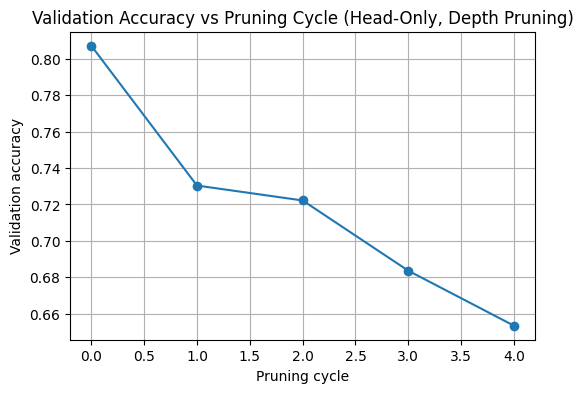

In [ ]:

# Plot with matplotlib (no seaborn, single plot, no explicit colors)
xs = [c for c, _ in val_acc_history]
ys = [acc for _, acc in val_acc_history]

plt.figure(figsize=(6,4))
plt.plot(xs, ys, marker='o')
plt.xlabel("Pruning cycle")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Pruning Cycle (Head-Only, Depth Pruning)")
plt.grid(True)
plt.show()


## (Optional) Final Test Evaluation

In [1]:

# Evaluate on the test set once you're done with all pruning cycles.
test_acc = evaluate(model, test_loader, device)
print(f"Final TEST accuracy: {test_acc:.4f}")


NameError: name 'evaluate' is not defined